In [1]:
import os
os.system("pip install ultralytics --quiet")
import shutil
import yaml
import random
import torch
import time
import subprocess
from ultralytics import YOLO
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import defaultdict
import hashlib
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Tue Sep 30 17:15:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8       

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Centralized Configuration for Easy Modification ---
# Project and Model Settings
model_name = 'yolo12m'  # The YOLO model you want to train (e.g., 'yolo12m.pt')
dataset_name = 'SAM Mark rubber disease final datasetss Computer Vision Model'
random_state = 42

# Path Settings
# Make sure the dataset is correctly uploaded to Google Drive in the specified path
gdrive_dataset_path = '/content/drive/MyDrive/rubber-disease-final-datasetss-4-mark/'
extracted_path = '/content/temp_rubber-disease-final-datasetss-4-mark/'
output_kfold_dir = os.path.join(extracted_path, 'kfold_yolo')

# Data Split Ratios
test_split_ratio = 0.1  # 20% of the data for the final test set
val_split_ratio = 0.2  # 20% of the remaining data for the validation set, only used if val=True
num_folds = 1 # Number of folds for cross-validation

device = '0' if torch.cuda.is_available() else 'cpu'

weight_path = '/content/drive/MyDrive/yolo12m_SAM Mark rubber disease final datasetss Computer Vision Model'
batch = 16            # ขนาดของชุดข้อมูล (batch size) default=16
imgsz = 640           # ขนาดของภาพ (image size) default=640

if num_folds > 1:
    # ถ้า num_folds มากกว่า 1 หมายความว่าเราจะทำ K-fold
    # ซึ่งในกระบวนการ K-fold จะมีการแบ่ง validation set ในแต่ละ fold อยู่แล้ว
    # จึงไม่จำเป็นต้องสร้าง validation set แยกต่างหากอีก
    val = False
    print(f"โหมดการทำงาน: {num_folds}-fold cross-validation")
    print("จะไม่สร้าง validation set แยกต่างหาก (val = False)")
else:
    # ถ้า num_folds เท่ากับ 1 หมายความว่าเราต้องการเทรนแบบปกติ
    # คือการแบ่งข้อมูลเป็น training set และ validation set เพียงครั้งเดียว
    val = True
    print("โหมดการทำงาน: Single train/validation split")
    print("จะสร้าง validation set แยกต่างหาก (val = True)")

โหมดการทำงาน: Single train/validation split
จะสร้าง validation set แยกต่างหาก (val = True)


In [5]:
# --- Helper Functions ---
def get_image_class_labels(labels_dir):
    """
    Reads label files to determine the primary class for each image.
    This is used for stratification to ensure a balanced split.
    If an image has multiple classes, it picks the first one.
    """
    image_labels = {}
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory not found at {labels_dir}")
        return image_labels

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            image_id = os.path.splitext(label_file)[0]
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()
                if lines:
                    # Pick the first class found in the label file for stratification
                    try:
                        class_id = int(lines[0].split()[0])
                        image_labels[image_id] = class_id
                    except (ValueError, IndexError):
                        # Handle malformed lines
                        image_labels[image_id] = -1
                else:
                    # Handle case with an empty label file
                    image_labels[image_id] = -1 # A placeholder for images with no objects
    return image_labels

def verify_and_count_data(data_dir, class_names):
    """
    Verifies the integrity of the split by counting images, labels, and bounding boxes.
    """
    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    # Check if directories exist
    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"  [ERROR] Directory not found: {data_dir}")
        return

    num_images = len(os.listdir(images_dir))
    num_labels = len(os.listdir(labels_dir))

    bbox_counts = defaultdict(int)
    total_bbox_count = 0

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.split()[0])
                        bbox_counts[class_id] += 1
                        total_bbox_count += 1
                    except (IndexError, ValueError):
                        # Skip malformed lines
                        continue

    print(f"  Number of images: {num_images}")
    print(f"  Number of labels: {num_labels}")
    print("  Bounding box counts per class:")
    for class_id, count in sorted(bbox_counts.items()):
        if class_id < len(class_names):
            print(f"    - Class {class_id} ({class_names[class_id]}): {count}")
        else:
            print(f"    - Class {class_id}: {count}")
    print(f"  Total number of bounding boxes: {total_bbox_count}")

def calculate_dir_hash(directory):
    """Calculates a consistent hash of a directory's contents."""
    hasher = hashlib.sha256()
    if not os.path.exists(directory):
        return None
    for root, _, files in os.walk(directory):
        for file in sorted(files):
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                while chunk := f.read(8192):
                    hasher.update(chunk)
    return hasher.hexdigest()

def verify_original_dataset(data_dir, class_names):
    """
    Counts images, labels, and bounding boxes in the original dataset root.
    """
    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"Error: 'images' or 'labels' directory not found in the original dataset root.")
        return

    num_images = len(os.listdir(images_dir))
    num_labels = len(os.listdir(labels_dir))

    bbox_counts = defaultdict(int)
    total_bbox_count = 0

    # Count bounding boxes and classes
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.split()[0])
                        bbox_counts[class_id] += 1
                        total_bbox_count += 1
                    except (IndexError, ValueError):
                        continue

    print(f"Number of images in {images_dir}: {num_images}")
    print(f"Number of labels in {labels_dir}: {num_labels}")

    print("Bounding box counts per class (Original Dataset):")
    for class_id, count in sorted(bbox_counts.items()):
        if class_id < len(class_names):
            print(f"  - Class {class_id} ({class_names[class_id]}): {count}")
        else:
            print(f"  - Class {class_id}: {count}")
    print(f"Total number of bounding boxes (Original Dataset): {total_bbox_count}")

In [6]:
# =================================================================
# --- 1. Data Ingestion (การนำเข้าข้อมูล) ---
# This part is responsible for copying and preparing the dataset.
# =================================================================

# Ensure the destination directory exists and is clean
if os.path.exists(extracted_path):
    shutil.rmtree(extracted_path)
os.makedirs(extracted_path, exist_ok=True)

# Copy the dataset from Google Drive
print(f"Copying {gdrive_dataset_path} to {extracted_path}...")
try:
    shutil.copytree(gdrive_dataset_path, extracted_path, dirs_exist_ok=True)
except FileNotFoundError:
    print(f"Error: Dataset not found at {gdrive_dataset_path}. Please check the path and try again.")
    exit()

# --- Find the zip file and unpack it using shutil ---
zip_file_path = None
for root, _, files in os.walk(extracted_path):
    for f in files:
        if f.endswith('.zip'):
            zip_file_path = os.path.join(root, f)
            break
    if zip_file_path:
        break

if zip_file_path:
    print(f"Successfully unpacked {zip_file_path} to {extracted_path}")
    try:
        shutil.unpack_archive(zip_file_path, extracted_path)
    except shutil.ReadError:
        print(f"Error: The file at {zip_file_path} is not a valid archive file that can be unpacked by shutil.")
        exit()
else:
    print("Warning: No zip file found in the copied directory. Assuming the data is already extracted.")

# --- Automatically find the correct dataset root directory ---
images_path, labels_path, data_yaml_path = None, None, None
dataset_root = None
for root, dirs, files in os.walk(extracted_path):
    if 'images' in dirs and 'labels' in dirs and 'data.yaml' in files:
        dataset_root = root
        images_path = os.path.join(dataset_root, 'images')
        labels_path = os.path.join(dataset_root, 'labels')
        data_yaml_path = os.path.join(dataset_root, 'data.yaml')
        break

if not images_path or not labels_path or not data_yaml_path:
    print("Error: Could not find the 'images', 'labels' directories and 'data.yaml' file within the extracted path.")
    exit()

# Load the data.yaml to get class information
try:
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    num_classes = data['nc']
    class_names = data['names']

    print(f"\nNumber of classes: {num_classes}")
    print(f"Class names: {class_names}")
except FileNotFoundError:
    print(f"Error: data.yaml not found at {data_yaml_path}. Please check your dataset structure.")
    exit()

# --- NEW: Verify and count the original dataset contents ---
verify_original_dataset(dataset_root, class_names)
print(f"Original dataset root hash: {calculate_dir_hash(dataset_root)}")


# Get all image file names
all_image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
all_image_ids = [os.path.splitext(f)[0] for f in all_image_files]

# Get a stratified list of labels for each image for splitting
image_labels_map = get_image_class_labels(labels_path)
stratify_labels = [image_labels_map.get(img_id, -1) for img_id in all_image_ids]

Copying /content/drive/MyDrive/rubber-disease-final-datasetss-4-mark/ to /content/temp_rubber-disease-final-datasetss-4-mark/...
Successfully unpacked /content/temp_rubber-disease-final-datasetss-4-mark/rubber-disease-final-datasetss-4-mark.zip to /content/temp_rubber-disease-final-datasetss-4-mark/

Number of classes: 3
Class names: ['Colletotrichum', 'Corynespora', 'Leaf-Blight']
Number of images in /content/temp_rubber-disease-final-datasetss-4-mark/images: 2684
Number of labels in /content/temp_rubber-disease-final-datasetss-4-mark/labels: 2684
Bounding box counts per class (Original Dataset):
  - Class 0 (Colletotrichum): 7436
  - Class 1 (Corynespora): 5139
  - Class 2 (Leaf-Blight): 3610
Total number of bounding boxes (Original Dataset): 16185
Original dataset root hash: 50a3cf841c5bcea597145fbd0a16ee0130fe6c780c29ebdcf4ad095f9c232580


In [7]:
# =================================================================
# --- 2. Data Splitting (การแบ่งข้อมูล) ---
# This part handles the main logic for single split vs k-fold.
# =================================================================

base_kfold_path = os.path.join(extracted_path, 'kfold_yolo')
if os.path.exists(base_kfold_path):
    shutil.rmtree(base_kfold_path)
os.makedirs(base_kfold_path, exist_ok=True)

# Main logic to handle single split vs k-fold
if num_folds > 1:
    if num_folds < 2:
        raise ValueError("K-fold cross-validation requires n_splits=2 or more.")
    print(f"\nRunning K-Fold Cross-Validation with {num_folds} folds.")
    # Step 1: Separate a fixed portion for the final Test Set
    train_val_ids, test_ids, _, _ = train_test_split(
        all_image_ids,
        stratify_labels,
        test_size=test_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=stratify_labels
    )

    # Step 2: Use Stratified K-Fold on the remaining data
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    train_val_labels = [image_labels_map.get(img_id, -1) for img_id in train_val_ids]
    fold_splits = skf.split(train_val_ids, train_val_labels)

else:
    print("\nRunning a single train/validation/test split.")
    # Step 1: Separate a fixed portion for the final Test Set
    train_val_ids, test_ids, _, _ = train_test_split(
        all_image_ids,
        stratify_labels,
        test_size=test_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=stratify_labels
    )

    # Step 2: Split the remaining data into Train and Validation sets
    train_ids, val_ids, _, _ = train_test_split(
        train_val_ids,
        [image_labels_map.get(img_id, -1) for img_id in train_val_ids],
        test_size=val_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=[image_labels_map.get(img_id, -1) for img_id in train_val_ids]
    )

    # Create a dummy fold split iterable to reuse the loop below
    fold_splits = [(list(range(len(train_ids))), list(range(len(val_ids))))]
    num_folds = 1

# Loop through the determined splits
for i, (train_index, val_index) in enumerate(fold_splits):
    fold_num = i + 1
    print(f"\n---------------------- Processing Fold {fold_num} ----------------------")

    # Adjust image IDs based on single split vs k-fold
    if num_folds > 1:
        fold_train_ids = [train_val_ids[idx] for idx in train_index]
        fold_val_ids = [train_val_ids[idx] for idx in val_index]
    else:
        fold_train_ids = train_ids
        fold_val_ids = val_ids

    # If val is False, add validation data to the training set.
    if not val:
        print("Note: 'val' is set to False. The validation data for this fold will be added to the training set.")
        fold_train_ids.extend(fold_val_ids)
        fold_val_ids = []

    # Verify the split ratios for this fold
    total_images_in_dataset = len(all_image_files)
    print(f"Total images in dataset: {total_images_in_dataset}")
    print(f"Train images: {len(fold_train_ids)} ({len(fold_train_ids)/total_images_in_dataset:.2%})")

    if val:
        print(f"Validation images: {len(fold_val_ids)} ({len(fold_val_ids)/total_images_in_dataset:.2%})")
    print(f"Test images: {len(test_ids)} ({len(test_ids)/total_images_in_dataset:.2%})")

    # Create output directories for the current fold
    fold_dir = os.path.join(output_kfold_dir, f'fold{fold_num}')
    if os.path.exists(fold_dir):
        shutil.rmtree(fold_dir)

    os.makedirs(os.path.join(fold_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'test', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'test', 'labels'), exist_ok=True)
    if val:
        os.makedirs(os.path.join(fold_dir, 'val', 'images'), exist_ok=True)
        os.makedirs(os.path.join(fold_dir, 'val', 'labels'), exist_ok=True)

    # --- Copy files to the respective directories with progress bar ---
    print("\nCopying files...")

    # Copy Test set
    for img_id in tqdm(test_ids, desc="Copying Test files"):
        if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
            shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'test', 'images'))
        if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
            shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'test', 'labels'))

    # Copy Training set
    for img_id in tqdm(fold_train_ids, desc="Copying Train files"):
        if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
            shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'train', 'images'))
        if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
            shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'train', 'labels'))

    # Copy Validation set
    if val and len(fold_val_ids) > 0:
        for img_id in tqdm(fold_val_ids, desc="Copying Validation files"):
            if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
                shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'val', 'images'))
            if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
                shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'val', 'labels'))

    # --- Create the YAML file for the current fold ---
    print("\nCreating YAML file...")
    yaml_content = {
        'path': fold_dir,
        'train': 'train/images',
        'test': 'test/images',
        'nc': num_classes,
        'names': class_names
    }

    if val:
        yaml_content['val'] = 'val/images'
    else:
        yaml_content['val'] = 'train/images'

    yaml_path = os.path.join(fold_dir, f'fold{fold_num}_data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)
    print(f"Created YAML file at: {yaml_path}")

    # --- Verify the contents of the new folders ---
    print("\nVerifying data counts and hash in each split:")
    print("  [TRAIN SET]")
    verify_and_count_data(os.path.join(fold_dir, 'train'), class_names)
    print(f"  Train set hash: {calculate_dir_hash(os.path.join(fold_dir, 'train'))}")
    if val:
        print("  [VALIDATION SET]")
        verify_and_count_data(os.path.join(fold_dir, 'val'), class_names)
        print(f"  Validation set hash: {calculate_dir_hash(os.path.join(fold_dir, 'val'))}")
    print("  [TEST SET]")
    verify_and_count_data(os.path.join(fold_dir, 'test'), class_names)
    print(f"  Test set hash: {calculate_dir_hash(os.path.join(fold_dir, 'test'))}")

print("\nAll folds have been created and verified!")
print(f"Final K-Fold directory hash: {calculate_dir_hash(output_kfold_dir)}")


Running a single train/validation/test split.

---------------------- Processing Fold 1 ----------------------
Total images in dataset: 2684
Train images: 1932 (71.98%)
Validation images: 483 (18.00%)
Test images: 269 (10.02%)

Copying files...


Copying Validation files: 100%|██████████| 483/483 [00:00<00:00, 2946.19it/s]



Creating YAML file...
Created YAML file at: /content/temp_rubber-disease-final-datasetss-4-mark/kfold_yolo/fold1/fold1_data.yaml

Verifying data counts and hash in each split:
  [TRAIN SET]
  Number of images: 1932
  Number of labels: 1932
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 5340
    - Class 1 (Corynespora): 3672
    - Class 2 (Leaf-Blight): 2545
  Total number of bounding boxes: 11557
  Train set hash: 2851c3de506ab0a56d82244e4ebdad01a74fa484bda021928b31af5e080576cb
  [VALIDATION SET]
  Number of images: 483
  Number of labels: 483
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 1220
    - Class 1 (Corynespora): 928
    - Class 2 (Leaf-Blight): 689
  Total number of bounding boxes: 2837
  Validation set hash: 1e790e267906e5cf443680ae3f7270e8960fa82fd967a62580aab56047c8944f
  [TEST SET]
  Number of images: 269
  Number of labels: 269
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 876
    - Class 1 (Corynespora): 539
    -

In [27]:
# ------------------ helper for robust per-class extraction ------------------
def _get_per_class_metric(metrics_box, num_classes, prefer_attrs=('ap50', 'ap', 'maps')):
    """
    Return a numpy array of length `num_classes` with the requested per-class metric.
    Prefer attributes in `prefer_attrs` order. If an attribute is missing or shorter than
    num_classes, pad with np.nan to length num_classes.
    """
    for attr in prefer_attrs:
        arr = getattr(metrics_box, attr, None)
        if arr is None:
            continue
        try:
            arr = np.array(arr, dtype=float)
        except Exception:
            continue
        if arr.size == 0:
            continue
        # pad or trim to num_classes
        if arr.size < num_classes:
            arr = np.pad(arr, (0, num_classes - arr.size), constant_values=np.nan)
        elif arr.size > num_classes:
            arr = arr[:num_classes]
        return arr
    # nothing found -> return nan array
    return np.full((num_classes,), np.nan)

def get_fold_support(test_labels_dir, class_names):
    """
    Count support (number of true instances) per class from YOLO label files.
    """
    support = {cls: 0 for cls in class_names}
    for label_file in os.listdir(test_labels_dir):
        if not label_file.endswith('.txt'):
            continue
        with open(os.path.join(test_labels_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls_idx = int(parts[0])
                if 0 <= cls_idx < len(class_names):
                    support[class_names[cls_idx]] += 1
    return support

def plot_confusion_matrix(cm, class_names, title, has_background=False):
    """
    Plots a confusion matrix.

    Args:
        cm: The confusion matrix data (numpy array).
        class_names: A list of class names.
        title: The title for the plot.
        has_background: Boolean to indicate if the background class should be included.
    """
    labels = class_names.copy()
    if has_background:
        labels.append('background')

    # Pad the matrix with zeros to include the background row/column if needed
    num_labels = len(labels)
    if cm.shape[0] < num_labels or cm.shape[1] < num_labels:
        full_cm = np.zeros((num_labels, num_labels))
        full_cm[:cm.shape[0], :cm.shape[1]] = cm
    else:
        full_cm = cm

    plt.figure(figsize=(10, 8))
    sns.heatmap(full_cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


======================== Testing Fold 1 ========================
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,225 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1480.1±638.4 MB/s, size: 83.7 KB)
val: Scanning /content/temp_rubber-disease-final-datasetss-4-mark/kfold_yolo/fold1/test/labels.cache... 269 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 269/269 420.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.3it/s 12.8s
                   all        269       1791      0.689      0.632      0.669      0.418
        Colletotrichum        150        876      0.659      0.309      0.408      0.201
           Corynespora        154        539      0.676       0.72      0.734      0.423
           Leaf-Blight        169        376      0.732      0.866      0.864      0.629
Speed: 1.6ms 

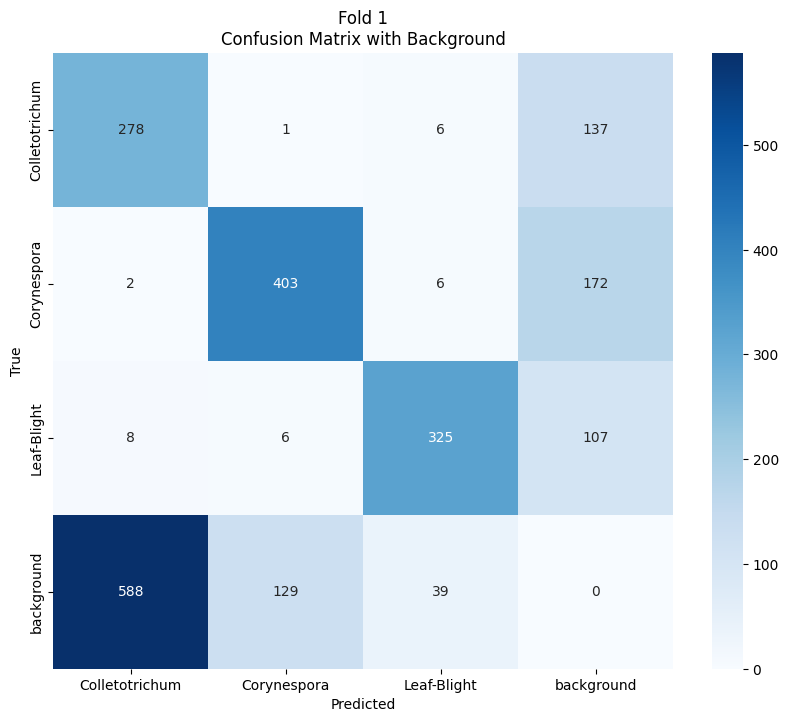

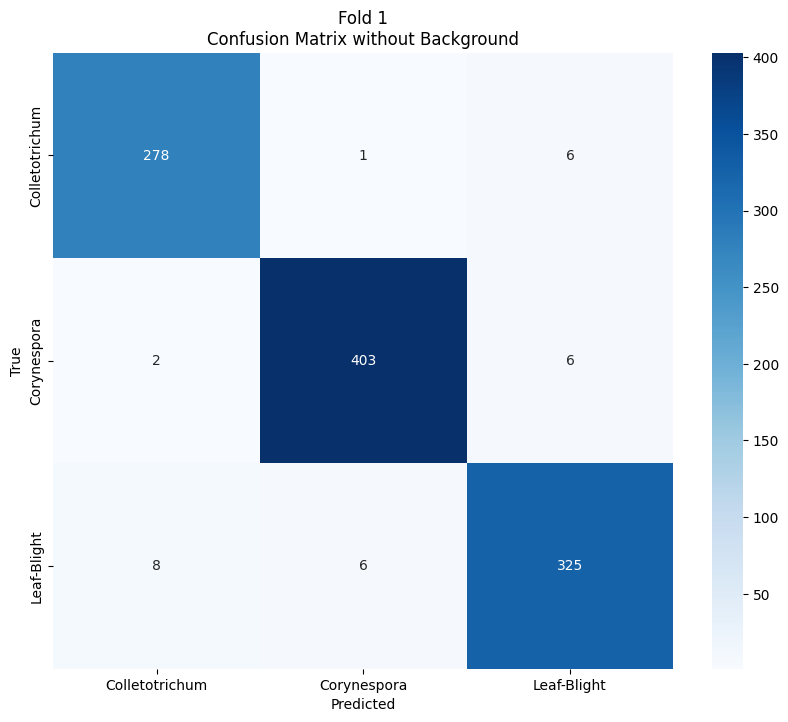

In [28]:
# ------------------ MAIN EXECUTION (REPLACEMENT) ------------------
fold_data_list = []
class_names = []

for i in range(num_folds):
    fold_num = i + 1
    fold_dir = os.path.join(output_kfold_dir, f'fold{fold_num}')
    fold_data_yaml = os.path.join(fold_dir, f'fold{fold_num}_data.yaml')
    test_labels_dir = os.path.join(fold_dir, 'test', 'labels')

    print(f"\n======================== Testing Fold {fold_num} ========================")

    best_model_path = os.path.join(weight_path, 'detect', f'{model_name}_fold{fold_num}', 'weights', 'best.pt')

    if os.path.exists(best_model_path):
        model_test = YOLO(best_model_path)

        results = model_test.val(
            data=fold_data_yaml,
            split='test',
            imgsz=imgsz,
            batch=batch,
            name=f'test_results_fold{fold_num}',
            exist_ok=True
        )

        if not class_names:
            class_names = list(results.names.values())

        num_classes = len(class_names)
        support = get_fold_support(test_labels_dir, class_names)

        cm_with_bg = results.confusion_matrix.matrix
        cm_no_bg = cm_with_bg[:num_classes, :num_classes]

        true_positives = np.diag(cm_no_bg)
        total_support = sum(support.values())
        accuracy = np.sum(true_positives) / total_support if total_support > 0 else 0

        # --- Correctly extract overall mAP50 and mAP50-95 scalars ---
        map50_overall = getattr(results.box, 'map50', None)
        map50_95_overall = getattr(results.box, 'map', None)

        if map50_overall is None or (isinstance(map50_overall, float) and np.isnan(map50_overall)):
            ap50_arr = getattr(results.box, 'ap50', None)
            if ap50_arr is not None and len(ap50_arr) > 0:
                map50_overall = float(np.nanmean(ap50_arr))
            else:
                maps_arr = getattr(results.box, 'maps', None)
                map50_overall = float(np.nanmean(maps_arr)) if (maps_arr is not None and len(maps_arr) > 0) else float('nan')

        if map50_95_overall is None or (isinstance(map50_95_overall, float) and np.isnan(map50_95_overall)):
            ap_arr = getattr(results.box, 'ap', None)
            if ap_arr is not None and len(ap_arr) > 0:
                map50_95_overall = float(np.nanmean(ap_arr))
            else:
                maps_arr = getattr(results.box, 'maps', None)
                map50_95_overall = float(np.nanmean(maps_arr)) if (maps_arr is not None and len(maps_arr) > 0) else float('nan')

        fold_data_list.append({
            'fold': fold_num,
            'metrics': results,
            'support': support,
            'cm_with_bg': cm_with_bg,
            'cm_no_bg': cm_no_bg,
            'accuracy': accuracy,
            'mAP50_overall': map50_overall,
            'mAP50-95_overall': map50_95_overall
        })

        print(f"\n--- Report for Fold {fold_num} ---")

        labels_no_bg = list(range(num_classes))
        class_names_no_bg = [class_names[i] for i in labels_no_bg]

        y_true_no_bg, y_pred_no_bg = [], []
        for t in range(len(cm_no_bg)):
            for p in range(len(cm_no_bg[t])):
                count = int(round(cm_no_bg[t, p]))
                if count > 0:
                    y_true_no_bg.extend([t] * count)
                    y_pred_no_bg.extend([p] * count)

        if not y_true_no_bg:
            print("No samples found in the confusion matrix.")
        else:
            print("\nClassification Report:")
            print(classification_report(y_true_no_bg, y_pred_no_bg, labels=labels_no_bg, target_names=class_names_no_bg, digits=4))

        print("-" * 50)

        plot_confusion_matrix(cm_with_bg, class_names, f'Fold {fold_num}\nConfusion Matrix with Background', has_background=True)
        plot_confusion_matrix(cm_no_bg, class_names, f'Fold {fold_num}\nConfusion Matrix without Background', has_background=False)

    else:
        print(f"Warning: Best model not found at {best_model_path}. Skipping test for fold {fold_num}.")



==================== Calculating Average Reports of All Folds ====================

Average Detection Report of All Folds:
                precision    recall  f1-score     mAP50    mAP50-95   support
-----------------------------------------------------------------------------
Colletotrichum     0.6587    0.3085    0.4202    0.4081      0.2014       876
Corynespora        0.6760    0.7201    0.6974    0.7344      0.4229       539
Leaf-Blight        0.7324    0.8663    0.7938    0.8644      0.6288       376
-----------------------------------------------------------------------------
overall avg        0.6891    0.6316    0.6591    0.6690      0.4177      1791
-----------------------------------------------------------------------------

Average Classification Report of All Folds:
                precision    recall  f1-score   support

Colletotrichum     0.9653    0.9754    0.9703       285
   Corynespora     0.9829    0.9805    0.9817       411
   Leaf-Blight     0.9644    0.9587  

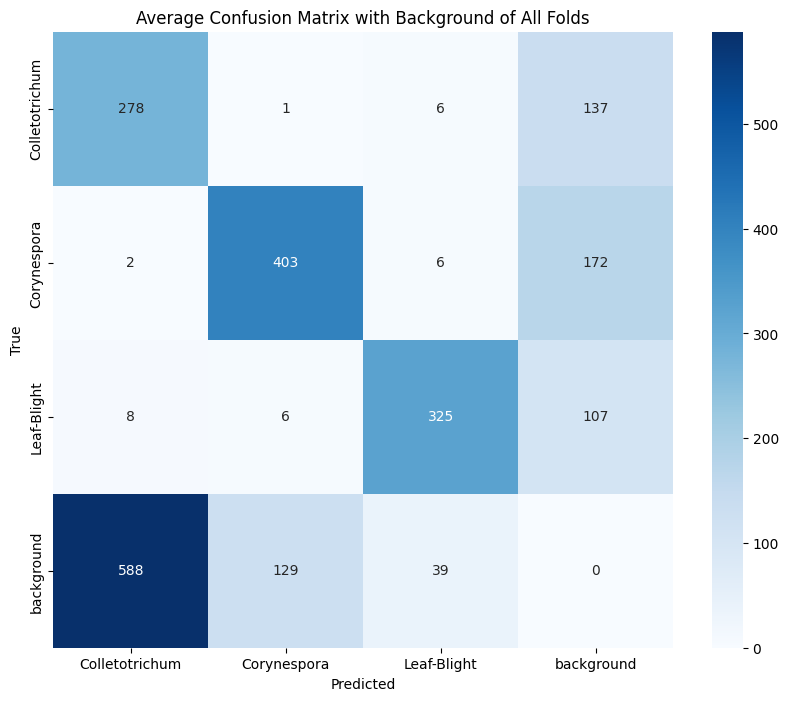

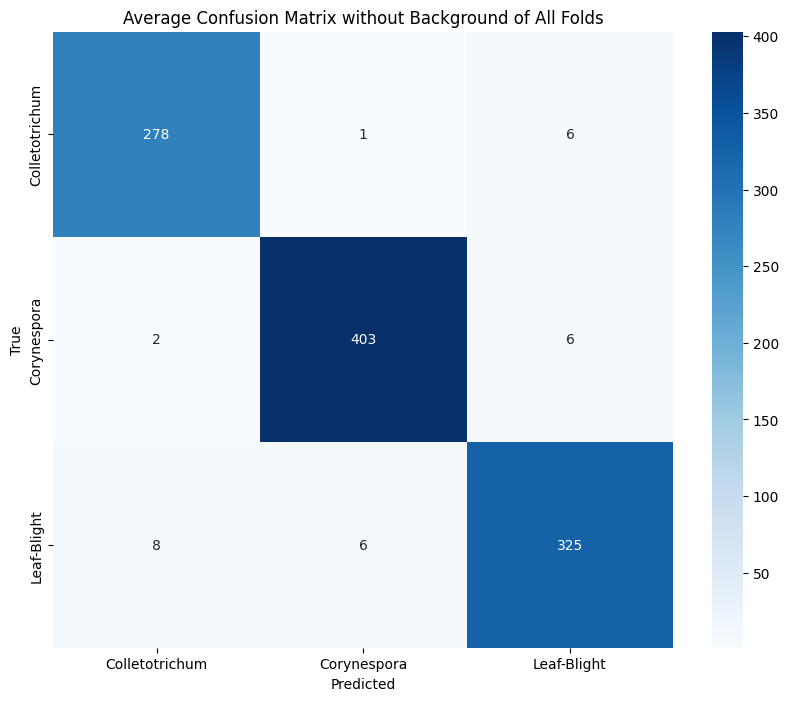


---------------------- All testing and reporting completed! ----------------------


In [29]:
# ------------------ SUMMARY AND AVERAGE REPORTS ------------------
if fold_data_list:
    print("\n\n==================== Calculating Average Reports of All Folds ====================")

    # Average per-class precision/recall/f1 (same as before)
    avg_precision = np.nanmean([d['metrics'].box.p for d in fold_data_list], axis=0)
    avg_recall = np.nanmean([d['metrics'].box.r for d in fold_data_list], axis=0)
    avg_f1 = (2 * avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-9)

    # --- CORRECT: use per-class AP50 arrays (.ap50) for avg_map50_per_class ---
    num_classes = len(class_names)
    per_fold_ap50 = [_get_per_class_metric(d['metrics'].box, num_classes, prefer_attrs=('ap50', 'maps', 'ap')) for d in fold_data_list]
    avg_map50_per_class = np.nanmean(per_fold_ap50, axis=0)

    # For mAP@0.5:0.95 per class (if needed), use prefer_attrs=('ap', 'maps')
    per_fold_ap = [_get_per_class_metric(d['metrics'].box, num_classes, prefer_attrs=('ap', 'maps')) for d in fold_data_list]
    avg_map50_95_per_class = np.nanmean(per_fold_ap, axis=0)

    # Averages of overall scalars already stored in fold_data_list
    overall_map50_avg = np.nanmean([d['mAP50_overall'] for d in fold_data_list])
    overall_map_50_95_avg = np.nanmean([d['mAP50-95_overall'] for d in fold_data_list])

    # Aggregate support counts
    avg_support = defaultdict(int)
    for data in fold_data_list:
        for k, v in data['support'].items():
            avg_support[k] += v

    print("\nAverage Detection Report of All Folds:")
    print(f"{'':<15s}{'precision':>10s}{'recall':>10s}{'f1-score':>10s}{'mAP50':>10s}{'mAP50-95':>12s}{'support':>10s}")
    print("-" * 77)

    total_support = sum(avg_support.values())

    if num_folds == 1:
        fold_metrics = fold_data_list[0]['metrics']
        fold_support = fold_data_list[0]['support']
        fold_overall_map50 = fold_data_list[0]['mAP50_overall']
        fold_overall_map_50_95 = fold_data_list[0]['mAP50-95_overall']

        for i, class_name in enumerate(class_names):
            p = fold_metrics.box.p[i] if i < len(fold_metrics.box.p) else 0
            r = fold_metrics.box.r[i] if i < len(fold_metrics.box.r) else 0
            f1 = (2 * p * r) / (p + r + 1e-9)
            # Use per-class AP50
            map50_per_class = fold_metrics.box.ap50[i] if hasattr(fold_metrics.box, 'ap50') and i < len(fold_metrics.box.ap50) else np.nan
            map_50_95_per_class = fold_metrics.box.ap[i] if hasattr(fold_metrics.box, 'ap') and i < len(fold_metrics.box.ap) else np.nan
            s = fold_support.get(class_name, 0)
            print(f"{class_name:<15s}{p:>10.4f}{r:>10.4f}{f1:>10.4f}{map50_per_class:>10.4f}{map_50_95_per_class:>12.4f}{s:>10d}")

        print("-" * 77)
        overall_p = np.nanmean(fold_metrics.box.p)
        overall_r = np.nanmean(fold_metrics.box.r)
        overall_f1 = (2 * overall_p * overall_r) / (overall_p + overall_r + 1e-9)

        print(f"{'overall avg':<15s}{overall_p:>10.4f}{overall_r:>10.4f}{overall_f1:>10.4f}{fold_overall_map50:>10.4f}{fold_overall_map_50_95:>12.4f}{total_support:>10d}")
        print("-" * 77)

    else:
        for i, class_name in enumerate(class_names):
            p = avg_precision[i] if i < len(avg_precision) else 0
            r = avg_recall[i] if i < len(avg_recall) else 0
            f1 = avg_f1[i] if i < len(avg_f1) else 0
            map50_per_class = avg_map50_per_class[i] if i < len(avg_map50_per_class) else np.nan
            map_50_95_per_class = avg_map50_95_per_class[i] if i < len(avg_map50_95_per_class) else np.nan
            s = avg_support.get(class_name, 0)
            print(f"{class_name:<15s}{p:>10.4f}{r:>10.4f}{f1:>10.4f}{map50_per_class:>10.4f}{map_50_95_per_class:>12.4f}{s:>10d}")

        print("-" * 77)
        overall_p = np.nanmean(avg_precision)
        overall_r = np.nanmean(avg_recall)
        overall_f1 = np.nanmean(avg_f1)

        print(f"{'overall avg':<15s}{overall_p:>10.4f}{overall_r:>10.4f}{overall_f1:>10.4f}{overall_map50_avg:>10.4f}{overall_map_50_95_avg:>12.4f}{total_support:>10d}")
        print("-" * 77)

    # Average confusion matrices
    avg_cm_with_bg = np.mean([d['cm_with_bg'] for d in fold_data_list], axis=0)
    avg_cm_no_bg = np.mean([d['cm_no_bg'] for d in fold_data_list], axis=0)

    # Average classification report
    print("\nAverage Classification Report of All Folds:")
    num_classes = len(class_names)
    avg_y_true_no_bg = []
    avg_y_pred_no_bg = []
    for t in range(num_classes):
        for p in range(num_classes):
            count = int(round(avg_cm_no_bg[t, p]))
            if count > 0:
                avg_y_true_no_bg.extend([t] * count)
                avg_y_pred_no_bg.extend([p] * count)

    if not avg_y_true_no_bg:
        print("No samples found in the average confusion matrix for classification report.")
    else:
        labels_no_bg = list(range(num_classes))
        class_names_no_bg = [class_names[i] for i in labels_no_bg]
        print(classification_report(avg_y_true_no_bg, avg_y_pred_no_bg, labels=labels_no_bg, target_names=class_names_no_bg, digits=4, zero_division=1))

    # Plot average confusion matrices
    plot_confusion_matrix(avg_cm_with_bg, class_names, 'Average Confusion Matrix with Background of All Folds', has_background=True)
    plot_confusion_matrix(avg_cm_no_bg, class_names, 'Average Confusion Matrix without Background of All Folds', has_background=False)

    print("\n---------------------- All testing and reporting completed! ----------------------")